In [1]:
import os
import copy
import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms

from eval import accuracy
from model import MnistCNN
from train import fit, evaluate
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28
DATASET = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [3]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)

    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

train_indexes, validation_indexes = split_indices(len(DATASET), 0.2)

train_sampler = SubsetRandomSampler(train_indexes)
train_loader = DataLoader(DATASET, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(validation_indexes)
val_loader = DataLoader(DATASET, BATCH_SIZE, sampler=val_sampler)

loss_fun = F.cross_entropy

def predict_image(image, model):
    xb = image.unsqueeze(0).to(dev)
    yb = model(xb)
    yb = yb.to(dev)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

def plot_graph(rng ,acc_list, lost_list, title):
    plt.plot(rng, acc_list, '-b', label='accuracy')
    plt.plot(rng, lost_list, '-r', label='loss')
    plt.legend(loc='upper left')
    plt.xlabel("amount pruned")
    plt.title(title)
    plt.show()


In [27]:
learning_rate = 0.001

model = MnistCNN().to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
fit(5, model, loss_fun, optimizer, train_loader, val_loader, accuracy)

Epoch 1, loss: 0.1084, accuracy: 0.9677
Epoch 2, loss: 0.0766, accuracy: 0.9753
Epoch 3, loss: 0.0820, accuracy: 0.9737
Epoch 4, loss: 0.0714, accuracy: 0.9793
Epoch 5, loss: 0.0730, accuracy: 0.9773


In [28]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1)
test_loss, total, test_acc = evaluate(model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Loss: 0.0614, accuracy: 0.9800


In [29]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

for name, module in model.named_children():
    module.register_forward_hook(get_activation(name))

In [30]:
activation = {}
def get_activation(name, input, output):
    print(f"{name} {input[0].shape} {output.shape}")

for name, module in model.named_children():
    module.register_forward_hook(get_activation)

In [100]:
def LRP_0(model : nn.Module, X):
    layers = [module for module in model.named_children() if not isinstance(module, torch.nn.Sequential)]
    L = len(layers)
    A = [X] + [X] * L 
    for layer in range(L):
        if layers[layer][0] == 'pool1':
            pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
            output1, indices1 = pool(A[layer])
            A[layer + 1] = output1
            continue
        if layers[layer][0] == 'pool2':
            pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
            output2, indices2 = pool(A[layer])
            A[layer + 1] = output2
            continue
        A[layer + 1] = layers[layer][1].forward(A[layer])

    T = A[-1].cpu().detach().numpy().tolist()[0]
    index = T.index(max(T))
    T = np.abs(np.array(T)) * 0
    T[index] = 1
    T = torch.FloatTensor(T)
    # Create the list of relevances with (L + 1) elements and assign the value of the last one 
    R = [None] * L + [(A[-1].cpu() * T).data + 1e-6]
    for layer in range(0, L)[::-1]:
        if layers[layer][0] == 'flatten':
            R[layer] = torch.reshape(A[layer], (32,7,7))
            continue
        if layers[layer][0] == 'pool2':
            unpool = nn.MaxUnpool2d(kernel_size=2)
            R[layer] = unpool(A[layer+1], indices2)
            continue
        if layers[layer][0] == 'pool1':
            unpool = nn.MaxUnpool2d(kernel_size=2)
            R[layer] = unpool(A[layer+1], indices1)
            continue
        if layers[layer][0] == 'relu1' or layers[layer][0] == 'relu2':
            R[layer] = A[layer + 1]
            continue
        A[layer] = A[layer].data.requires_grad_(True)
        z = newlayer(layers[layer][1]).forward(A[layer]) + 1e-9
        s = (R[layer+1].to(dev) / z).data
        (z * s).sum().backward()
        c = A[layer].grad
        R[layer] = (A[layer] * c).cpu().data 
    return R[0]
        


def newlayer(layer : nn.Module) -> nn.Module:
    layer = copy.deepcopy(layer)
    layer.weight = torch.nn.Parameter(layer.weight)
    layer.bias = torch.nn.Parameter(layer.bias)
    return layer

Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) torch.Size([1, 1, 28, 28]) torch.Size([1, 16, 28, 28])
ReLU() torch.Size([1, 16, 28, 28]) torch.Size([1, 16, 28, 28])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([1, 16, 28, 28]) torch.Size([1, 16, 14, 14])
Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) torch.Size([1, 16, 14, 14]) torch.Size([1, 32, 14, 14])
ReLU() torch.Size([1, 32, 14, 14]) torch.Size([1, 32, 14, 14])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([1, 32, 14, 14]) torch.Size([1, 32, 7, 7])
Flatten(start_dim=1, end_dim=-1) torch.Size([1, 32, 7, 7]) torch.Size([1, 1568])
Linear(in_features=1568, out_features=10, bias=True) torch.Size([1, 1568]) torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


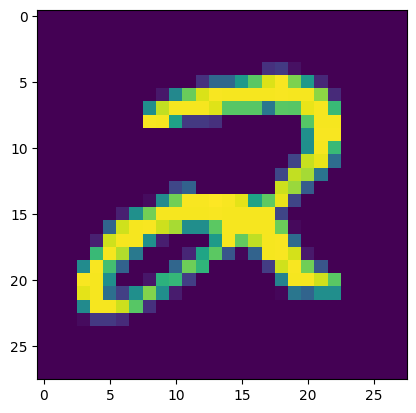

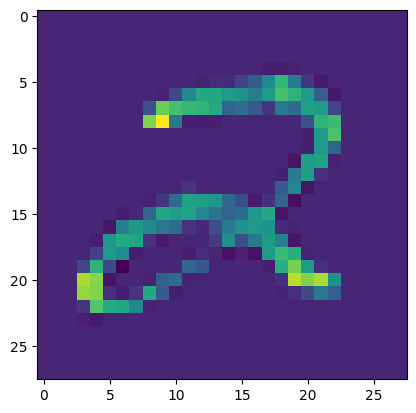

In [104]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
image, label = next(iter(test_loader))
model(image.to(dev))
print(image.shape)
img = image.squeeze(0).permute(1,2,0).numpy()
plt.imshow(img)
lrp = LRP_0(model, image.to(dev))
print(lrp.shape)
img = lrp.squeeze(0).permute(1,2,0).numpy()
plt.figure()
plt.imshow(img)